## Data collection and processing of the Pacific Ocean

In [1]:
# Importing packages
import gdal
import pandas as pd
import numpy as np
import geopandas as gpd
from io import StringIO
from shapely.geometry import Point
import osr
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import seaborn as sns
import os
import sys
sys.path.insert(0, os.path.abspath(''))

import data_processing_helper as dp
import practical_functions as pf
import xarray as xr
import pygrib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
import requests as rq
import shapely
from shapely import wkt
from shapely.wkt import loads
plt.style.use('ggplot') # use ggplot style

/home/lavinia/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Loading the Shapefiles for the Pacific

In [2]:
gdf_AUS = gpd.read_file('../Data/Reefs/shp_GBR/Reefs_GBR.shp')
gdf_IND = gpd.read_file('../Data/Reefs/shp_indonesia/indonesia.shp')
gdf_TLS = gpd.read_file('../Data/Reefs/shp_timorleste/timorleste.shp')
gdf_SLB = gpd.read_file('../Data/Reefs/shp_solomon/solomon.shp')

# Combining the shapefiles
gdf_PAC = gpd.GeoDataFrame(pd.concat([gdf_AUS, gdf_IND, gdf_TLS, gdf_SLB]))

## Loading the Survey folder
It contains the coordinates of the Survey and the percentage of algae, corals, soft_corals or other_invertebrates


In [6]:
Survey_global = pd.read_csv("../Data/Reefs/seaviewsurvey_surveys.csv")
Survey_global.head()

,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,20120916,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,20120917,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,20120918,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,20120920,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,20120920,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


In [7]:
Survey = Survey_global[(Survey_global["country"] == "AUS") | (Survey_global["country"] == "IDN") | (Survey_global["country"] == "TLS")| (Survey_global["country"] == "SLB")]
print("We now have a total of :",Survey.shape[0], " Surveys")
Survey.head()

We now have a total of : 421  Surveys


,surveyid,transectid,surveydate,ocean,country,folder_name,lat_start,lng_start,lat_end,lng_end,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other
0,10001,10001,20120916,PAC,AUS,PAC_AUS_10001_201209,-16.189023,145.898104,-16.191761,145.894088,0.1856,0.3724,0.2710,0.0010,0.1700
1,10002,10002,20120917,PAC,AUS,PAC_AUS_10002_201209,-16.189303,145.898254,-16.175947,145.889736,0.1364,0.4766,0.3079,0.0020,0.0771
2,10003,10003,20120918,PAC,AUS,PAC_AUS_10003_201209,-16.175768,145.891676,-16.181218,145.888904,0.2475,0.5653,0.0747,0.0207,0.0917
3,10004,10004,20120920,PAC,AUS,PAC_AUS_10004_201209,-16.536645,147.806796,-16.524287,147.843325,0.1242,0.5706,0.0279,0.0023,0.2748
4,10005,10005,20120920,PAC,AUS,PAC_AUS_10005_201209,-16.529216,147.802582,-16.521689,147.836180,0.0781,0.7894,0.0096,0.0029,0.1201


In [8]:
# Change date format 
Survey['surveydate'] = pd.to_datetime(Survey['surveydate'], format='%Y%m%d')

In [9]:
# Make pacific survey into GeoDataFrame
gSurvey = gpd.GeoDataFrame(Survey, geometry = gpd.points_from_xy(Survey.lat_start, Survey.lng_start))
gSurvey["country"].value_counts()

AUS    261
IDN    114
TLS     26
SLB     20
Name: country, dtype: int64

We can see that most surveys were taken in Australia followed by Indonesia. With a total of 421 surveys

In [10]:
# Keep only month and year
gSurvey['surveydate'] = gSurvey['surveydate'].dt.strftime('%Y-%m')

In [11]:
# Same content but only for Australia 
Survey_AUS = Survey_global[Survey_global['country'] == 'AUS']


In [12]:
shape_GBR = gpd.read_file("../Data/GBR_shapes_surveys/Reefs_GBR.shp")
#ax = shape_GBR.plot()
#ax.set_title("GBR shape file")


In [13]:
# Make geo data frame 
gSurvey_AUS = gpd.GeoDataFrame(Survey_AUS, geometry = gpd.points_from_xy(Survey_AUS.lng_start, Survey_AUS.lat_start))

## Wind speed
https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=form


For these coordinates:


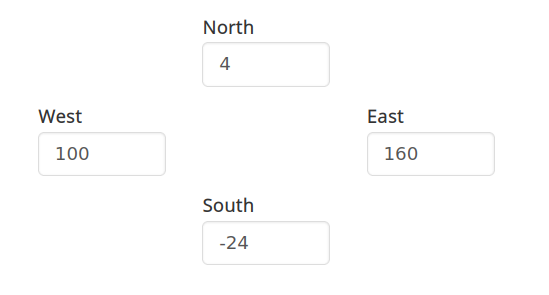



**Be careful, various users have stated how slow this download is** : https://confluence.ecmwf.int/pages/viewpage.action?pageId=143050283



In [17]:
# Load xarray
ds_wind = xr.open_dataset("../Data/Environmental_data/wind_monthly.nc")

In [18]:
# Make dataframe
df_wind = ds_wind.to_dataframe()


In [19]:
# Rename and reset longitude and latitude index
df_wind.rename(columns = {"si10":"wind_speed"}, inplace = True)


In [20]:
df_wind.reset_index(inplace = True)

In [21]:
gdf_wind = gpd.GeoDataFrame(df_wind, geometry=gpd.points_from_xy(df_wind.latitude, df_wind.longitude))
# Keep only month and year
gdf_wind["time"] = gdf_wind["time"].dt.strftime('%Y-%m')

In [22]:
# Drop useless columns
gdf_wind.drop(columns = ['latitude', 'longitude', 'number', 'step', 'surface',
       'valid_time'], inplace = True)
gSurvey.drop(columns = ['surveyid', 'ocean', 
       'folder_name', 'lat_end', 'lng_end',
       'pr_hard_coral', 'pr_algae', 'pr_soft_coral', 'pr_oth_invert',
       'pr_other'], inplace = True)

In [23]:
# Look at the dates which are unique within the survey (month and year)
dates_surveys = gSurvey['surveydate'].unique()

In [24]:
frames_all = dp.merge_(gSurvey,gdf_wind, dates_surveys)

In [26]:
# Add wind_speed to geoframe
gSurvey["wind_speed"] = frames_all["wind_speed"].to_list()

In [27]:
gSurvey.shape

(421, 7)

In [28]:
Survey.drop(columns = ['surveyid', 'ocean', 'country',
       'folder_name', 'lat_start', 'lng_start', 'lat_end', 'lng_end',
        'geometry'], inplace = True)

In [29]:
# Merge with Survey
df_merge_w = pd.merge(Survey, gSurvey,on = ["surveydate","transectid"], how = "left")

In [30]:
dups_sur_trans = df_merge_w.pivot_table(index=['surveydate','transectid'], aggfunc='size')
print (dups_sur_trans.value_counts())
print("You have 5 surveys with 4 duplicates...remove to ease computation")

1    411
4      5
dtype: int64
You have 5 surveys with 4 duplicates...remove to ease computation


In [31]:
dups_sur_trans[dups_sur_trans == 4]

surveydate  transectid
2014-05     12029         4
2018-06     32003         4
            32024         4
            32026         4
            32030         4
dtype: int64

In [32]:
# Here I drop the duplicates on time and transectid, indeed I could just take the mean of them instead of 
# keeping only first value
df_mer_w = df_merge_w.drop_duplicates(subset=["surveydate","transectid"], keep="first", inplace = False)

### Chlorophyll Copernicus



import cdsapi
def import_chloro(year_list, name):
    c = cdsapi.Client()

    c.retrieve(
        'satellite-ocean-colour',
        {
            'format': 'tgz',
            'variable': 'mass_concentration_of_chlorophyll_a',
            'projection': 'regular_latitude_longitude_grid',
            'year': year_list,
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'day': '01',
            'version': '5.0',
        },
        '%s.tar.gz' %name)


import_chloro(["2012", "2014"], "chlorophyll_12_14")
import_chloro(["2016", "2017"], "chlorophyll_16_17")
import_chloro(["2018"], "chlorophyll_18")

ds_chlor = xr.open_mfdataset("../Data/Environmental_data/chlorophyll/ESACCI-OC-L3S-CHLOR_A-MERGED-1D_DAILY_4km*.nc")

# Bounds of coordinates for Pacific
latbounds = [-24, 4]
lonbounds = [100, 160]
lats = ds_chlor.variables["lat"][:]
lons = ds_chlor.variables["lon"][:]
# latitude lower and upper index
latli = np.argmin( np.abs( lats - latbounds[0] ).values )
latui = np.argmin( np.abs( lats - latbounds[1] ).values ) 
# longitude lower and upper index
lonli = np.argmin( np.abs( lons - lonbounds[0] ).values )
lonui = np.argmin( np.abs( lons - lonbounds[1] ).values )  



# Subset for the given coordinates
ChlorSubset = ds_chlor.variables['chlor_a'][ : , latui:latli , lonli:lonui ] 


# Dataset with the chlor amongst the different coordinates
ds_sub_chlor = xr.Dataset(data_vars={"Chlor": ChlorSubset}, coords = {"lon":ds_chlor["lon"][lonli:lonui], "lat": ds_chlor["lat"][latui:latli], "time":ds_chlor["time"]})


df_chlor = ds_sub_chlor.to_dataframe()



df_chlor.reset_index(inplace = True)

# Many NaN values
df_chlor.head()

df_chlor.to_csv("../Data/Environmental_data/df_chlor.csv", index = False)

In [33]:
df_chlor = pd.read_csv("../Data/Environmental_data/df_chlor.csv")
df_chlor.head()

,lat,lon,time,Chlor
0,3.979167,100.020833,2012-02-01,0.647330
1,3.979167,100.020833,2016-03-01,0.601783
2,3.979167,100.020833,2016-08-01,0.573502
3,3.979167,100.020833,2017-01-01,0.612619
4,3.979167,100.020833,2017-06-01,0.750544


In [34]:
# Change to datetime format
df_chlor['time'] = pd.to_datetime(df_chlor['time'], errors='coerce')

In [35]:
# Keep only month and year 
df_chlor["time"] = df_chlor["time"].dt.strftime('%Y-%m')
df_chlor.head()

,lat,lon,time,Chlor
0,3.979167,100.020833,2012-02,0.647330
1,3.979167,100.020833,2016-03,0.601783
2,3.979167,100.020833,2016-08,0.573502
3,3.979167,100.020833,2017-01,0.612619
4,3.979167,100.020833,2017-06,0.750544


In [36]:
gdf_chlor = gpd.GeoDataFrame(df_chlor, geometry=gpd.points_from_xy(df_chlor.lat, df_chlor.lon))

print(gdf_chlor.head())

        lat         lon     time     Chlor               geometry
0  3.979167  100.020833  2012-02  0.647330  POINT (3.979 100.021)
1  3.979167  100.020833  2016-03  0.601783  POINT (3.979 100.021)
2  3.979167  100.020833  2016-08  0.573502  POINT (3.979 100.021)
3  3.979167  100.020833  2017-01  0.612619  POINT (3.979 100.021)
4  3.979167  100.020833  2017-06  0.750544  POINT (3.979 100.021)


In [38]:
df_merged_w_ch = dp.merge_(df_mer_w, gdf_chlor, dates_surveys)


In [39]:
df_mer_w["Chlor"] = df_merged_w_ch["Chlor"].to_list()
df_merged_w_ch = df_mer_w

In [40]:
df_merged_w_ch.to_csv("../Data/Environmental_data/merged_wind_chlor.csv", index = False)

In [41]:
df_merged_w_ch = pd.read_csv("../Data/Environmental_data/merged_wind_chlor.csv")
df_merged_w_ch.head()


,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,lat_start,lng_start,geometry,wind_speed,Chlor
0,10001,2012-09,0.1856,0.3724,0.2710,0.0010,0.1700,AUS,-16.189023,145.898104,POINT (-16.1890227 145.8981037),6.939368,0.122235
1,10002,2012-09,0.1364,0.4766,0.3079,0.0020,0.0771,AUS,-16.189303,145.898254,POINT (-16.1893027 145.8982542),6.939368,0.122235
2,10003,2012-09,0.2475,0.5653,0.0747,0.0207,0.0917,AUS,-16.175768,145.891676,POINT (-16.1757678 145.8916764),6.939368,0.122235
3,10004,2012-09,0.1242,0.5706,0.0279,0.0023,0.2748,AUS,-16.536645,147.806796,POINT (-16.5366452 147.8067956),6.992591,0.103763
4,10005,2012-09,0.0781,0.7894,0.0096,0.0029,0.1201,AUS,-16.529216,147.802582,POINT (-16.5292156 147.8025816),6.992591,0.103763


In [42]:
from shapely import wkt


df_merged_w_ch['geometry'] = df_merged_w_ch['geometry'].apply(wkt.loads)

## Solar radiation Copernicus


In [43]:
# Load xarray
ds_solar = xr.open_dataset("../Data/Environmental_data/solar_rad.nc")

In [44]:
# Surface net solar radiation, clear sky :: SSRC [J m**-2]
# Surface net solar radiation :: SSR [J m**-2]
# Make dataframe
df_solar = ds_solar.to_dataframe()

In [45]:
# Rename and reset longitude and latitude index
df_solar.rename(columns = {"ssr":"solar_rad", "ssrc":"solar_rad_clear_sky"}, inplace = True)

In [46]:
df_solar.reset_index(inplace = True)
df_solar.head()

,latitude,longitude,time,number,step,surface,valid_time,solar_rad,solar_rad_clear_sky
0,4.0,100.0,2011-12-31 18:00:00,0,0 days 12:00:00,0,2012-01-01 06:00:00,18220032.0,22505472.0
1,4.0,100.0,2012-01-31 18:00:00,0,0 days 12:00:00,0,2012-02-01 06:00:00,18947584.0,23912960.0
2,4.0,100.0,2012-02-29 18:00:00,0,0 days 12:00:00,0,2012-03-01 06:00:00,18467456.0,24934656.0
3,4.0,100.0,2012-03-31 18:00:00,0,0 days 12:00:00,0,2012-04-01 06:00:00,18638336.0,24757248.0
4,4.0,100.0,2012-04-30 18:00:00,0,0 days 12:00:00,0,2012-05-01 06:00:00,17528320.0,23803392.0


In [47]:
df_solar.drop(columns = ['number','time', 'step', 'surface'], inplace = True)

In [48]:

# Keep only month and year 
df_solar["valid_time"] = df_solar["valid_time"].dt.strftime('%Y-%m')
df_solar.head()

,latitude,longitude,valid_time,solar_rad,solar_rad_clear_sky
0,4.0,100.0,2012-01,18220032.0,22505472.0
1,4.0,100.0,2012-02,18947584.0,23912960.0
2,4.0,100.0,2012-03,18467456.0,24934656.0
3,4.0,100.0,2012-04,18638336.0,24757248.0
4,4.0,100.0,2012-05,17528320.0,23803392.0


In [49]:
gdf_solar = gpd.GeoDataFrame(df_solar, geometry=gpd.points_from_xy(df_solar.latitude, df_solar.longitude))
gdf_solar.rename(columns = {"valid_time" : "time"}, inplace = True)

In [50]:
df_merged_w_ch_sol = dp.merge_(df_merged_w_ch, gdf_solar, dates_surveys)


In [51]:
df_merged_w_ch_sol.head()

,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,lat_start,lng_start,geometry,wind_speed,Chlor,latitude,longitude,time,solar_rad,solar_rad_clear_sky,dist
0,10001,2012-09,0.1856,0.3724,0.2710,0.0010,0.1700,AUS,-16.189023,145.898104,POINT (-16.1890227 145.8981037),6.939368,0.122235,-16.25,146.00,2012-09,20889976.0,23943344.0,0.118748
1,10002,2012-09,0.1364,0.4766,0.3079,0.0020,0.0771,AUS,-16.189303,145.898254,POINT (-16.1893027 145.8982542),6.939368,0.122235,-16.25,146.00,2012-09,20889976.0,23943344.0,0.118475
2,10003,2012-09,0.2475,0.5653,0.0747,0.0207,0.0917,AUS,-16.175768,145.891676,POINT (-16.1757678 145.8916764),6.939368,0.122235,-16.25,146.00,2012-09,20889976.0,23943344.0,0.131318
3,10004,2012-09,0.1242,0.5706,0.0279,0.0023,0.2748,AUS,-16.536645,147.806796,POINT (-16.5366452 147.8067956),6.992591,0.103763,-16.50,147.75,2012-09,21851000.0,23912112.0,0.067591
4,10005,2012-09,0.0781,0.7894,0.0096,0.0029,0.1201,AUS,-16.529216,147.802582,POINT (-16.5292156 147.8025816),6.992591,0.103763,-16.50,147.75,2012-09,21851000.0,23912112.0,0.060153


In [52]:
df_merged_w_ch["solar_rad"] = df_merged_w_ch_sol["solar_rad"].to_list()
df_merged_w_ch["solar_rad_clear_sky"] = df_merged_w_ch_sol["solar_rad_clear_sky"].to_list()
df_merged_w_ch_sol = df_merged_w_ch

In [53]:
df_merged_w_ch_sol.to_csv("../Data/Environmental_data/merged_wind_chlor_sol.csv", index = False)

## Ocean depth Copernicus // Sentinel 3

#Ocean level, so negative numbers are for below water :)

In [56]:
df_merged_w_ch_sol = pd.read_csv("../Data/Environmental_data/merged_wind_chlor_sol.csv")

In [57]:
# Load xarray for depth
ds_depth = xr.open_dataset("../Data/Environmental_data/depth/depth.nc")

In [58]:
# Set latitude and longitude as index
df_merged_w_ch_sol_ind = df_merged_w_ch_sol.set_index(["lat_start", "lng_start"])

In [59]:
# Make a NetCDF with the multi-index dataframe 
xr_merged = xr.Dataset.from_dataframe(df_merged_w_ch_sol_ind)
xr_merged = xr_merged.rename({"lat_start" : "lat"})
xr_merged= xr_merged.rename({"lng_start" : "lon"})

In [60]:
# Keep interesting lat/long
long_ = [xr_merged["lon"].values]
latg_ = [xr_merged["lat"].values]
df_depth_near = ds_depth.sel(lon=long_[0], lat=latg_[0], method='nearest')
depth_same_coord = df_depth_near.assign_coords(lon = long_[0], lat = latg_[0])
xr_merged_depth = xr_merged.merge(depth_same_coord, join = "inner")

In [61]:
df_depth_merged = xr_merged_depth.to_dataframe()
df_depth_merged.head(2)

transectid surveydate  pr_hard_coral  pr_algae  \
lat        lon                                                          
-23.513029 110.181207         NaN        NaN            NaN       NaN   
           110.181230         NaN        NaN            NaN       NaN   

                       pr_soft_coral  pr_oth_invert  pr_other country  \
lat        lon                                                          
-23.513029 110.181207            NaN            NaN       NaN     NaN   
           110.181230            NaN            NaN       NaN     NaN   

                      geometry  wind_speed  Chlor  solar_rad  \
lat        lon                                                 
-23.513029 110.181207      NaN         NaN    NaN        NaN   
           110.181230      NaN         NaN    NaN        NaN   

                       solar_rad_clear_sky  elevation  
lat        lon                                         
-23.513029 110.181207                  NaN      -4923  
           110.181230                  NaN      -4923

In [76]:
df_merged = df_depth_merged.dropna().reset_index()

### Degree geometryting Week 

In [65]:
def treat_SST_DHW(df, gdf):
    df["id"] = df["id"].str.replace('R', "").astype(int)
    
    df = df.merge(gdf[["id", "geometry"]], how='left')
    df.dropna(inplace = True)
    
    df_temp = df.drop(columns = ["id", "geometry"])
    df_temp.columns = pd.to_datetime(df_temp.columns)
    df_temp.columns = df_temp.columns.strftime("%Y-%m")
    df_temp.insert(0, "id", df["id"])
    df_temp.insert(0, "geometry", df["geometry"])
    df = df_temp.copy()
    df = pf.make_geo_frame(df)
    return df
    
    
    

In [77]:
# Degree Heating week and SST

DHW_IDN = pd.read_csv("../Data/Environmental_data/DHW_Indonesia.csv")
DHW_IDN = treat_SST_DHW(DHW_IDN, gdf_IND)
from shapely.wkt import loads
df_merged['geometry'] = df_merged['geometry'].apply(wkt.loads)
SST_IDN = pd.read_csv("../Data/Environmental_data/SST_Indonesia.csv")
SST_IDN = treat_SST_DHW(SST_IDN, gdf_IND)
df_merged = pf.make_geo_frame(df_merged)

In [78]:
df_swap = df_merged.copy()
df_swap["geometry"] = df_swap.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))

In [79]:
# Take the intersection
# nothing in common...
DHW_merged_IDN = gpd.sjoin(DHW_IDN, df_swap[df_swap["country"] == "IDN"], how="inner", op='intersects')
print("DHW merged: ", DHW_merged_IDN.shape)
SST_merged_IDN = gpd.sjoin(SST_IDN, df_swap[df_swap["country"] == "IDN"], how="inner", op='intersects')
print("SST merged: ", SST_merged_IDN.shape)

DHW merged:  (0, 447)
SST merged:  (0, 447)


In [80]:
# Let us use another strategy. I will take the centroid of the polygon and estimate the closests neighbor
DHW_IDN.geometry = DHW_IDN['geometry'].centroid
df_near_merge_IDN_DHW = dp.ckdnearest(df_swap[df_swap["country"] == "IDN"], DHW_IDN).drop(columns = "dist")

SST_IDN.geometry = SST_IDN['geometry'].centroid
df_near_merge_IDN_SST = dp.ckdnearest(df_swap[df_swap["country"] == "IDN"], SST_IDN).drop(columns = "dist")

In [81]:
# Same for both SST and DHW
dates_to_drop = df_near_merge_IDN_DHW.columns[17:][df_near_merge_IDN_DHW.columns[17:].isin(df_near_merge_IDN_DHW["surveydate"]) == False]
dates_to_keep = df_near_merge_IDN_DHW.columns[17:][df_near_merge_IDN_DHW.columns[17:].isin(df_near_merge_IDN_DHW["surveydate"])]
df_near_merge_IDN_SST.drop(columns = dates_to_drop,  inplace = True)
df_near_merge_IDN_DHW.drop(columns = dates_to_drop,  inplace = True)

In [82]:
df_near_merge_IDN_DHW['DHW'] = df_near_merge_IDN_DHW.lookup(df_near_merge_IDN_DHW.index, df_near_merge_IDN_DHW['surveydate'].astype(str))
df_near_merge_IDN_DHW.drop(columns = dates_to_keep,  inplace = True)
df_near_merge_IDN_SST['SST'] = df_near_merge_IDN_SST.lookup(df_near_merge_IDN_SST.index, df_near_merge_IDN_SST['surveydate'].astype(str))
df_near_merge_IDN_SST.drop(columns = dates_to_keep,  inplace = True)

In [83]:
df_near_merge_IDN = df_near_merge_IDN_DHW.copy()
df_near_merge_IDN["SST"] = df_near_merge_IDN_SST['SST']

# Indonesia done

In [84]:
# Timor 
# Degree Heating week and SST
DHW_TLS = pd.read_csv("../Data/Environmental_data/DHW_Timor.csv")
DHW_TLS = treat_SST_DHW(DHW_TLS, gdf_TLS)
SST_TLS = pd.read_csv("../Data/Environmental_data/SST_Timor.csv")
SST_TLS = treat_SST_DHW(SST_TLS, gdf_TLS)

In [85]:
#  Nothing in common
DHW_merged_TLS = gpd.sjoin(DHW_TLS, df_swap[df_swap["country"] == "TLS"], how="inner", op='intersects')
print("DHW merged: ", DHW_merged_TLS.shape)
SST_merged_TLS = gpd.sjoin(SST_TLS, df_swap[df_swap["country"] == "TLS"], how="inner", op='intersects')
print("SST merged: ", SST_merged_TLS.shape)

DHW merged:  (0, 447)
SST merged:  (0, 447)


In [86]:
# Same centroid strategy
DHW_TLS.geometry = DHW_TLS['geometry'].centroid
df_near_merge_TLS_DHW = dp.ckdnearest(df_swap[df_swap["country"] == "TLS"], DHW_TLS)

SST_TLS.geometry = SST_TLS['geometry'].centroid
df_near_merge_TLS_SST = dp.ckdnearest(df_swap[df_swap["country"] == "TLS"], SST_TLS)


In [87]:
# Same for both SST and DHW
dates_to_drop = df_near_merge_TLS_DHW.columns[17:][df_near_merge_TLS_DHW.columns[17:].isin(df_near_merge_TLS_DHW["surveydate"]) == False]
dates_to_keep = df_near_merge_TLS_DHW.columns[17:][df_near_merge_TLS_DHW.columns[17:].isin(df_near_merge_TLS_DHW["surveydate"])]
df_near_merge_TLS_SST.drop(columns = dates_to_drop,  inplace = True)
df_near_merge_TLS_DHW.drop(columns = dates_to_drop,  inplace = True)

In [88]:
df_near_merge_TLS_DHW['DHW'] = df_near_merge_TLS_DHW.lookup(df_near_merge_TLS_DHW.index, df_near_merge_TLS_DHW['surveydate'].astype(str))
df_near_merge_TLS_DHW.drop(columns = dates_to_keep,  inplace = True)
df_near_merge_TLS_SST['SST'] = df_near_merge_TLS_SST.lookup(df_near_merge_TLS_SST.index, df_near_merge_TLS_SST['surveydate'].astype(str))
df_near_merge_TLS_SST.drop(columns = dates_to_keep,  inplace = True)
df_near_merge_TLS = df_near_merge_TLS_DHW.copy()
df_near_merge_TLS["SST"] = df_near_merge_TLS_SST['SST']
df_near_merge_TLS.head(2)

,lat,lon,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,geometry,wind_speed,Chlor,solar_rad,solar_rad_clear_sky,elevation,id,DHW,SST
0,-9.186476,124.391635,30023.0,2014-07,0.2536,0.3902,0.1027,0.0472,0.2063,TLS,POINT (124.39163 -9.18648),3.709066,0.406888,16667136.0,18682368.0,-85,17651,0.0,27.668065
1,-9.173817,124.409284,30022.0,2014-07,0.1146,0.3139,0.0755,0.0350,0.4609,TLS,POINT (124.40928 -9.17382),3.709066,0.406888,16667136.0,18682368.0,-15,17651,0.0,27.668065


In [89]:
# Solomon
# Degree Heating week and SST
DHW_SLB = pd.read_csv("../Data/Environmental_data/DHW_Indonesia.csv")
DHW_SLB = treat_SST_DHW(DHW_SLB, gdf_SLB)
SST_SLB = pd.read_csv("../Data/Environmental_data/SST_Solomon.csv")
SST_SLB = treat_SST_DHW(SST_SLB, gdf_SLB)

In [90]:
# Nothing in common for DHW and 11 for SST
DHW_merged_SLB = gpd.sjoin(DHW_SLB, df_swap[df_swap["country"] == "SLB"], how="inner", op='intersects')
print("DHW merged: ", DHW_merged_SLB.shape)
SST_merged_SLB = gpd.sjoin(SST_SLB, df_swap[df_swap["country"] == "SLB"], how="inner", op='intersects')
print("SST merged: ", SST_merged_SLB.shape)

DHW merged:  (0, 447)
SST merged:  (11, 447)


In [91]:
# Same
DHW_SLB.geometry = DHW_SLB['geometry'].centroid
df_near_merge_SLB_DHW = dp.ckdnearest(df_swap[df_swap["country"] == "SLB"], DHW_SLB)
SST_SLB.geometry = SST_SLB['geometry'].centroid
df_near_merge_SLB_SST = dp.ckdnearest(df_swap[df_swap["country"] == "SLB"], SST_SLB)


In [92]:
# Same for both SST and DHW
dates_to_drop = df_near_merge_SLB_DHW.columns[17:][df_near_merge_SLB_DHW.columns[17:].isin(df_near_merge_SLB_DHW["surveydate"]) == False]
dates_to_keep = df_near_merge_SLB_DHW.columns[17:][df_near_merge_SLB_DHW.columns[17:].isin(df_near_merge_SLB_DHW["surveydate"])]
df_near_merge_SLB_SST.drop(columns = dates_to_drop,  inplace = True)
df_near_merge_SLB_DHW.drop(columns = dates_to_drop,  inplace = True)

In [93]:
df_near_merge_SLB_DHW['DHW'] = df_near_merge_SLB_DHW.lookup(df_near_merge_SLB_DHW.index, df_near_merge_SLB_DHW['surveydate'].astype(str))
df_near_merge_SLB_DHW.drop(columns = dates_to_keep,  inplace = True)
df_near_merge_SLB_SST['SST'] = df_near_merge_SLB_SST.lookup(df_near_merge_SLB_SST.index, df_near_merge_SLB_SST['surveydate'].astype(str))
df_near_merge_SLB_SST.drop(columns = dates_to_keep,  inplace = True)
df_near_merge_SLB = df_near_merge_SLB_DHW.copy()
df_near_merge_SLB["SST"] = df_near_merge_SLB_SST['SST']
df_near_merge_SLB.head(2)

,lat,lon,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,geometry,wind_speed,Chlor,solar_rad,solar_rad_clear_sky,elevation,id,DHW,SST
0,-8.701401,157.815640,34016.0,2014-11,0.1154,0.8454,0.0167,0.0147,0.0075,SLB,POINT (157.81564 -8.70140),4.663486,0.170505,19759616.0,26144256.0,-46,16975,0.0,29.344
1,-8.676629,157.839278,34015.0,2014-11,0.1362,0.6395,0.0342,0.0037,0.1865,SLB,POINT (157.83928 -8.67663),4.663486,0.170505,19759616.0,26144256.0,-5,16975,0.0,29.421


In [94]:
# Great Barrier Reef

# Degree Heating week and SST
DHW_GBR = pd.read_csv("../Data/Environmental_data/DHW_GBR.csv")
gdf_AUS["id"] = gdf_AUS["id"].str.replace('R', "").astype(int)
DHW_GBR = treat_SST_DHW(DHW_GBR, gdf_AUS)
SST_GBR = pd.read_csv("../Data/Environmental_data/SST_GBR.csv")
SST_GBR = treat_SST_DHW(SST_GBR, gdf_AUS)


In [95]:
# 206 / 260 are merged within for the rest let us take the closest point
DHW_merged_GBR = gpd.sjoin(df_swap[df_swap["country"] == "AUS"],DHW_GBR,  how="inner", op='intersects')
SST_merged_GBR = gpd.sjoin(df_swap[df_swap["country"] == "AUS"],SST_GBR, how="inner", op='intersects')
print("For GBR_DHW: ", DHW_merged_GBR.shape, " in common")
print("For GBR_SST: ", SST_merged_GBR.shape, " in common")

For GBR_DHW:  (206, 447)  in common
For GBR_SST:  (206, 447)  in common


In [96]:
temp_DHW = DHW_merged_GBR[DHW_merged_GBR.columns[:16]]
temp_SST = SST_merged_GBR[SST_merged_GBR.columns[:16]]

In [97]:
df_diff_neig_DHW = pd.concat([temp_DHW,df_swap[df_swap["country"] == "AUS"]]).drop_duplicates(keep=False)
df_diff_neig_SST = pd.concat([temp_SST,df_swap[df_swap["country"] == "AUS"]]).drop_duplicates(keep=False)

In [98]:
# Let us use anothgeometrystrategy. I will take the centroid of the polygon and estimate the closests neighbor
DHW_GBR.geometry = DHW_GBR['geometry'].centroid
df_near_DHW = dp.ckdnearest(df_diff_neig_DHW,DHW_GBR)

# Let us use another strategy. I will take the centroid of the polygon and estimate the closests neighbor
SST_GBR.geometry = SST_GBR['geometry'].centroid
df_near_SST = dp.ckdnearest(df_diff_neig_SST,SST_GBR)


In [99]:
DHW_GBR_year = df_near_DHW.append(DHW_merged_GBR).drop(columns = "dist")
SST_GBR_year = df_near_SST.append(SST_merged_GBR).drop(columns = "dist")
SST_GBR_year.index = np.arange(260)
DHW_GBR_year.index = np.arange(260)

In [100]:
# Same for both SST and DHW
dates_to_drop = DHW_GBR_year.columns[17:][DHW_GBR_year.columns[17:].isin(DHW_GBR_year["surveydate"]) == False]
dates_to_keep = DHW_GBR_year.columns[17:][DHW_GBR_year.columns[17:].isin(DHW_GBR_year["surveydate"])]
SST_GBR_year.drop(columns = dates_to_drop,  inplace = True)
DHW_GBR_year.drop(columns = dates_to_drop,  inplace = True)

In [101]:
DHW_GBR_year['DHW'] = DHW_GBR_year.lookup(DHW_GBR_year.index, DHW_GBR_year['surveydate'].astype(str))
DHW_GBR_year.drop(columns = dates_to_keep,  inplace = True)
SST_GBR_year['SST'] = SST_GBR_year.lookup(SST_GBR_year.index, SST_GBR_year['surveydate'].astype(str))
SST_GBR_year.drop(columns = dates_to_keep,  inplace = True)
df_near_merge_GBR = DHW_GBR_year.copy()
df_near_merge_GBR["SST"] = SST_GBR_year['SST']
df_near_merge_GBR.head(2)

,lat,lon,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,geometry,wind_speed,Chlor,solar_rad,solar_rad_clear_sky,elevation,id,DHW,SST
0,-18.833291,147.651632,11002.0,2012-10,0.1586,0.6852,0.0978,0.0216,0.0366,AUS,POINT (147.65163 -18.83329),6.969212,0.155895,23342080.0,26556928.0,-34,41573,0.0,25.307097
1,-17.698393,148.513366,10013.0,2012-09,0.0986,0.5873,0.0167,0.0099,0.2874,AUS,POINT (148.51337 -17.69839),6.625403,0.174489,21595512.0,23705776.0,-18,47314,0.0,24.838333


In [102]:
## Now combine all of them 
# df_near_merge_GBR, df_near_merge_SLB, df_near_merge_IDN, df_near_merge_TLS

df_Survey_merged = pd.concat([df_near_merge_GBR,df_near_merge_SLB, df_near_merge_IDN, df_near_merge_TLS]).drop_duplicates(keep=False)
print("Shape ",df_Survey_merged.shape)
df_Survey_merged.head(3)

Shape  (416, 19)


,lat,lon,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,geometry,wind_speed,Chlor,solar_rad,solar_rad_clear_sky,elevation,id,DHW,SST
0,-18.833291,147.651632,11002.0,2012-10,0.1586,0.6852,0.0978,0.0216,0.0366,AUS,POINT (147.65163 -18.83329),6.969212,0.155895,23342080.0,26556928.0,-34,41573,0.0,25.307097
1,-17.698393,148.513366,10013.0,2012-09,0.0986,0.5873,0.0167,0.0099,0.2874,AUS,POINT (148.51337 -17.69839),6.625403,0.174489,21595512.0,23705776.0,-18,47314,0.0,24.838333
2,-16.175264,145.891157,10003.0,2017-10,0.1385,0.5264,0.0324,0.0058,0.2968,AUS,POINT (145.89116 -16.17526),6.687017,0.297231,21459968.0,26170368.0,-2,29655,0.0,26.130000


In [104]:
df_Survey_merged.to_csv("../Data/Environmental_data/merged_before_port.csv", index = False)

In [259]:
df_Survey_merged = pd.read_csv("../Data/Environmental_data/merged_before_port.csv")

In [260]:

df_Survey_merged['geometry'] = df_Survey_merged['geometry'].apply(wkt.loads)
df_Survey_merged = pf.make_geo_frame(df_Survey_merged)

In [261]:

df_Survey_merged["geometry"] = df_Survey_merged.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))

### PAR

In [262]:
d1 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20122452012274.L3m_MO_PAR.x_par.nc")
d2 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20122752012305.L3m_MO_PAR.x_par.nc")
d3 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20123062012335.L3m_MO_PAR.x_par.nc")
d4 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20123362012366.L3m_MO_PAR.x_par.nc")
d6 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20140322014059.L3m_MO_PAR_par_4km.nc")
d7 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20141212014151.L3m_MO_PAR_par_4km.nc")
d8 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20141822014212.L3m_MO_PAR_par_4km.nc")
d9 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20142132014243.L3m_MO_PAR_par_4km.nc")
d10 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20142442014273.L3m_MO_PAR_par_4km.nc")
d11 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20142742014304.L3m_MO_PAR_par_4km.nc")
d12 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20143052014334.L3m_MO_PAR_par_4km.nc")
d13 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20143352014365.L3m_MO_PAR_par_4km.nc")
d14 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20160612016091.L3m_MO_PAR_par_4km.nc")
d15 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20162752016305.L3m_MO_PAR_par_4km.nc")
d16 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20163062016335.L3m_MO_PAR_par_4km.nc")
d17 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20172742017304.L3m_MO_PAR_par_4km.nc")
d18 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20181212018151.L3m_MO_PAR_par_4km.nc")
d19 = xr.open_dataset("../Data/Environmental_data/PAR_month/requested_files/A20181522018181.L3m_MO_PAR_par_4km.nc")


In [263]:
df_PAR = [d1, d2, d3, d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19]


In [264]:
def PAR_pre(ds_PAR_list, df, Survey_dates):
    df_conc = []
    i = 0
    for date in Survey_dates:
        ds_PAR_list[i] = ds_PAR_list[i].drop(labels = "palette")
        df_part = df[df["surveydate"] == date]
        df1 = df_part.copy()
        df1.set_index(["lat", "lon"],inplace = True)
        xr_merged = xr.Dataset.from_dataframe(df1)
        # Keep interesting lat/long
        
        long_ = [xr_merged["lon"].values]
        latg_ = [xr_merged["lat"].values]
        
        df_par_near = ds_PAR_list[i].sel(lon=long_[0], lat=latg_[0], method='nearest')
        same_coord = df_par_near.assign_coords(lon = long_[0], lat = latg_[0])
        xr_merged_ = xr_merged.merge(same_coord, join = "inner")
        
        df_frame = xr_merged_.to_dataframe()
        df_ = df_frame.dropna().reset_index()
        df_conc.append(df_)
        i = i + 1
    return pd.concat(df_conc)
        

In [265]:
df_Survey_PAR = PAR_pre(df_PAR, df_Survey_merged, Survey_dates)

In [266]:
df_Survey_PAR.to_csv("../Data/Environmental_data/df_env_merged_par.csv")

In [3]:
df_Survey_merged = pd.read_csv("../Data/Environmental_data/df_env_merged_par.csv")

In [7]:
df_Survey_merged.drop(columns = "Unnamed: 0", inplace = True)

In [22]:

df_Survey_merged['geometry'] = df_Survey_merged['geometry'].apply(wkt.loads)
df_Survey_merged = pf.make_geo_frame(df_Survey_merged)

### Port

In [9]:
from osgeo import gdal

inputfile = '../Data/Environmental_data/distance-from-port-v1.tiff'
outputfile = '../Data/Environmental_data/distance-from-port.nc'
#Do not change this line, the following command will convert the geoTIFF to a netCDF
ds = gdal.Translate(outputfile, inputfile, format='NetCDF')

In [10]:
ds_port_dist = xr.open_dataset("../Data/Environmental_data/distance-from-port.nc")

In [11]:
# Bounds of coordinates for Pacific
latbounds = [-24, 4]
lonbounds = [110, 160]
lats = ds_port_dist.variables["lat"][:]
lons = ds_port_dist.variables["lon"][:]
# latitude lower and upper index
latli = np.argmin( np.abs( lats - latbounds[0] ).values )
latui = np.argmin( np.abs( lats - latbounds[1] ).values ) 
# longitude lower and upper index
lonli = np.argmin( np.abs( lons - lonbounds[0] ).values )
lonui = np.argmin( np.abs( lons - lonbounds[1] ).values )  




In [12]:
# Subset for the given coordinates
PortSubset = ds_port_dist.variables['Band1'][latli:latui , lonli:lonui ] 


In [13]:
# Dataset with the chlor amongst the different coordinates
ds_sub_port = xr.Dataset(data_vars={"Port_dist": PortSubset}, coords = {"lon":ds_port_dist["lon"][lonli:lonui], "lat": ds_port_dist["lat"][latli:latui]})


In [14]:
df_port = ds_sub_port.to_dataframe()


In [15]:
df_port.reset_index(inplace = True)

In [16]:
# remove the Nan values, so that it automatically takes the other ones that are closest
df_port = df_port.dropna(axis = 0)

In [17]:
gdf_port = gpd.GeoDataFrame(df_port, geometry=gpd.points_from_xy(df_port.lat, df_port.lon))

print(gdf_port.head())

    lat     lon   Port_dist                 geometry
0 -24.0  110.00  345.815704  POINT (-24.000 110.000)
1 -24.0  110.01  344.802856  POINT (-24.000 110.010)
2 -24.0  110.02  343.790009  POINT (-24.000 110.020)
3 -24.0  110.03  342.777191  POINT (-24.000 110.030)
4 -24.0  110.04  341.764404  POINT (-24.000 110.040)


In [18]:
gdf_port.drop(columns = ["lat", "lon"], inplace = True)

In [24]:
Closest_port = dp.nearest_neighbor(df_Survey_merged, gdf_port, return_dist=True)

In [32]:
Closest_port

,Port_dist,geometry,distance
0,60.447258,POINT (-18.830 147.650),404.245121
1,63.403625,POINT (-18.810 147.670),416.935248
2,79.639008,POINT (-18.670 147.720),520.150084
3,80.634659,POINT (-18.660 147.720),601.594003
4,82.516258,POINT (-18.590 147.570),533.509550
...,...,...,...
411,34.628056,POINT (-8.220 125.530),174.526710
412,35.853439,POINT (-8.210 125.620),321.991143
413,39.474037,POINT (-8.180 125.640),442.709526
414,1.099620,POINT (-8.540 125.610),386.734287


In [33]:
df_Survey_merged["closest_port"] = Closest_port["distance"]

In [34]:
df_Survey_merged

,lat,lon,transectid,surveydate,pr_hard_coral,pr_algae,pr_soft_coral,pr_oth_invert,pr_other,country,...,wind_speed,Chlor,solar_rad,solar_rad_clear_sky,elevation,id,DHW,SST,par,closest_port
0,-18.833291,147.651632,11002.0,2012-10,0.1586,0.6852,0.0978,0.0216,0.0366,AUS,...,6.969212,0.155895,23342080.0,26556928.0,-34.0,41573.0,0.0,25.307097,50.354000,404.245121
1,-18.806353,147.669078,11001.0,2012-10,0.1141,0.6164,0.0497,0.0024,0.2173,AUS,...,6.969212,0.144960,23342080.0,26556928.0,-1.0,41573.0,0.0,25.307097,50.343998,416.935248
2,-18.665839,147.722256,11004.0,2012-10,0.0331,0.8568,0.0230,0.0068,0.0805,AUS,...,6.969212,0.223738,23342080.0,26556928.0,-2.0,41909.0,0.0,25.405806,49.325996,520.150084
3,-18.656207,147.724072,11003.0,2012-10,0.0485,0.9070,0.0225,0.0098,0.0121,AUS,...,6.969212,0.223738,23342080.0,26556928.0,-2.0,41909.0,0.0,25.405806,49.325996,601.594003
4,-18.590921,147.565032,11005.0,2012-10,0.4016,0.4756,0.0185,0.0046,0.0998,AUS,...,6.929661,0.946051,23284736.0,26554368.0,-11.0,40890.0,0.0,25.543548,50.809998,533.509550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,-8.221244,125.530967,30018.0,2014-07,0.1706,0.6726,0.0805,0.0244,0.0520,TLS,...,5.920492,0.176333,18820608.0,19874304.0,148.0,17651.0,0.0,27.668065,56.494000,174.526710
412,-8.211822,125.622274,30014.0,2014-07,0.1706,0.5924,0.1170,0.0689,0.0510,TLS,...,5.920492,0.270113,18820608.0,19874304.0,16.0,17651.0,0.0,27.668065,54.964000,321.991143
413,-8.183781,125.638740,30013.0,2014-07,0.1273,0.7098,0.0633,0.0483,0.0513,TLS,...,6.554770,0.226052,18669568.0,19847680.0,-820.0,17651.0,0.0,27.668065,55.288000,442.709526
414,-8.538504,125.606825,30026.0,2014-08,0.1017,0.5661,0.2066,0.0140,0.1117,TLS,...,2.934158,0.404360,20266496.0,21339136.0,10.0,17651.0,0.0,27.077097,42.652000,386.734287


In [35]:
df_Survey_merged.to_csv("../Data/Environmental_data/df_env_merged.csv", index = False)

In [29]:
# Fetch the environmentally merged data :)

df_Survey_merged = pd.read_csv("../Data/Environmental_data/df_env_merged.csv")

In [30]:
Survey_dates = df_Survey_merged["surveydate"].unique()

In [55]:
import requests
import xml.etree.ElementTree as ET

r = requests.get('',  auth=('user', 'pass'))
tree = ET.parse(r.text)
root = tree.getroot()

FileNotFoundError: [Errno 2] No such file or directory: '\n\n\n\n\n\n\n\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">\n\t<head>\n\t    <title>Login</title>\n\t\t<link href="http://marine.copernicus.eu/favicon.ico" rel="shortcut icon" type="image/x-icon" />\n\t\t<!-- link rel="icon" type="image/png" href="http://myo-wp.techworks.ie/devel/templates/myocean/favicon.png" /-->>\n\t    <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />\n\n\n\t\t\n\t\t<link rel="stylesheet" type="text/css" href="/cas/newCss/css/myocean/screen/content.css" media="all" />\n\t\t<link rel="stylesheet" type="text/css" href="/cas/newCss/css/myocean/screen/content_cc.css" media="all" />\n\t\t<link rel="stylesheet" type="text/css" href="/cas/newCss/css/myocean/screen/patch_content_cc.css" media="all" />\n\t\t<link rel="stylesheet" type="text/css" href="/cas/newCss/css/cssmanager.php?version=4.0.2-1288885946&amp;files=/cas/newCss/css/myocean/print/print_003.css" media="print" />\n\t\t\n\t    <!--[if gte IE 6]><style type="text/css" media="screen">@import \'css/ie_cas.css\';</style><![endif]-->\n\t    <script type="text/javascript" src="js/common_rosters.js"></script>\n\t\t<style type="text/css">\ninput.submit{cursor:pointer}\n</style>\n\t</head>\n\t\n\t<body id="cas"  class="claro" onload="init();" >\n\n\t\n\t\n\t\t<div id="white_background_inner_page" style="height:105px;"></div>\n\t\t<div id="col3_content" class="clearfix">\n\t\t\n\n\t\t\t<img src="/css/myocean/print/images/logo_myocean_print.png" width="1" height="1" align="left" id="logoPrint" alt="" />\n\t\t\t<div id="breadcrumb">\n\t\t\t\t<a href="http://marine.copernicus.eu/">Home</a> &gt; Login\n\t\t\t</div>\n\n\t\t\t\n\t\t\t\n\t\t\t<h1>Welcome to the CMEMS Data Access Portal</h1>\n\t\t\t<br/>\n\t\t\t<p>Fill your login/password and click on <strong>Login</strong> to download data. If you are not registred yet click on <a href="http://marine.copernicus.eu/web/56-user-registration-form.php" target="_parent">Register</a></p>\n            <p>If you have trouble logging in, make sure your browser is set to accept cookies.</p>\n            <br/>\n\t\n\t\n\t\n\t\n\t\t\t<form id="authentification" name="com-login" class="fm-v clearfix" action="/cas/login;jsessionid=42279A95A1319233B9F26DA29BEC83B3?service=https%3A%2F%2Fmy.cmems-du.eu%2Fmotu-web%2FMotu%3Faction%3Ddescribeproduct%26service%3DGLOBAL_REANALYSIS_PHY_001_030-TDS%26product%3Dglobal-reanalysis-phy-001-030-monthly.xml" method="post">\n\n\t\t\t    \n\t\t\t\t\t<fieldset class="input">\n\t\t\t\t\t\n\t\t\t\t\t\t<label for="username">Username</label>\n\t\t\t\t\t\t<input id="username" name="username" class="required" tabindex="1" accesskey="i" type="text" value="" size="25" autocomplete="false"/><br />\n\t\t\t\t\t\t\n\t\t\t\t\t\t<label for="password">Password</label>\n\t\t\t\t\t\t<input id="password" name="password" class="required" tabindex="2" accesskey="m" type="password" value="" size="25" autocomplete="off"/><br />\n\n\t\t\t\t\t\t<input type="hidden" name="lt" value="_cA1D8C5AE-148E-D749-8EC8-FABFF29FE428_k65AF6780-B114-BE7F-1102-D1FC62665A43" />\n\t\t\t\t\t\t<input type="hidden" name="_eventId" value="submit" />\n                      \n\t\t\t\t\t\t<div class="authentification_retrait_right">\n\t\t\t\t\t\t\t<a href="http://marine.copernicus.eu/web/56-user-registration-form.php" target="_parent"><img src="/cas/newCss/css/myocean/screen/images/bt_register.gif" alt="Register" /></a>\n\t\t\t\t\t\t\t<input class="submit" name="submit" accesskey="l" value=" " type="submit" alt="Login" />\n\t\t\t\t\t\t</div>\n\n\t\t\t\t\t</fieldset>\n               \n\t            <p>\n\t\t\t\t\t<br/><br/>\n\t\t\t\t\t<i>- You are registered but have forgotten your login/password?</i><br/>\n\t\t\t\t\t<i>- Any question?</i><br/>\n\t\t\t\t\t<b>&rArr; CMEMS Service Desk : </b><A HREF="mailto:servicedesk.cmems@mercator-ocean.eu"><b>servicedesk.cmems@mercator-ocean.eu</b></A>\n\t\t\t\t</p>\n\n\t\t\t</form>\t\n\t\t\t\t\n\t\t\t\t<h3>Thank you for using CMEMS products</h3>\n\t\t\t\t<br/>\n\t            <div id="sidebar">\n\t                <i>For security reasons, please Exit your web browser when you quit services requiring authentication!</i>\n\t            </div>\n        \t\n\t\t</div>\n\t    \n\t</body>\n</html>\n\n'